Оптимальная точка встречи: (55.772439, 37.633854)
Время от каждого человека: от A (driving-car): 6.0 мин, от B (foot-walking): 31.5 мин, от C (cycling-regular): 33.3 мин, от D (driving-car): 32.4 мин


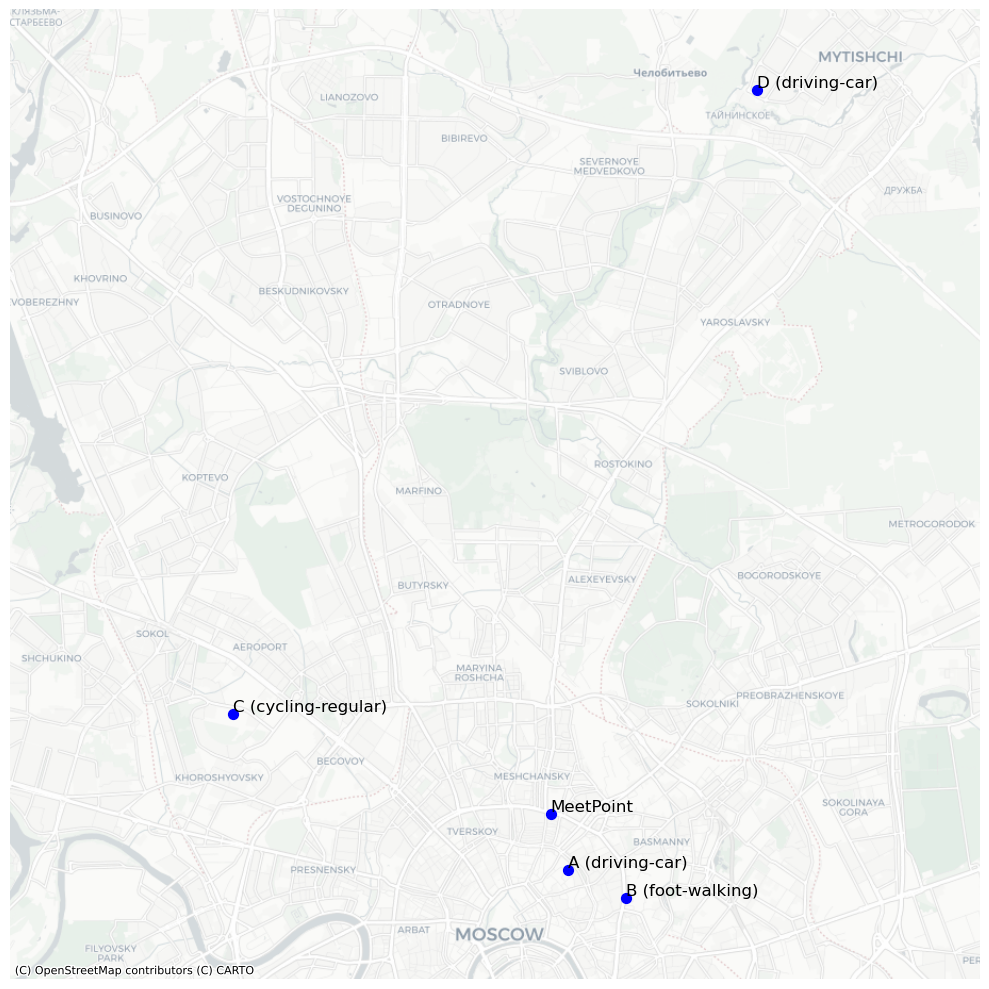

In [1]:
import os
from collections import defaultdict

import contextily as cx  # type: ignore
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from routingpy import ORS  # type: ignore
from shapely.geometry import Point, Polygon

"""
Поиск оптимальной точки встречи для трёх людей или более,
которые двигаются на любом виде транспорта по графу.
Точки-прекандидаты располагаются в полигоне, охватывающем всех людей.
Точки-кандидаты располагаются около наилучшей точки из точек прекандидатов.
"""

# TODO:
# Сейчас даже точки кандидатов могу находиться очень далеко друг от друга
# Нужно либо прекандидатов привязать к графу, чтобы они не лежали в промках и уменьшить область поиска для кандидатов
# Либо отбирать кандидатов не рандомные точки, а POI в зависомости от сценария.
# А лучше и то и другое, особенно если первый шаг не затратный по времени.
# Второй шаг в OSM можно сделать как отобрать POI по количеству заполненных атрибутов.

ORS_API_KEY = os.getenv("ORS_API_KEY")
SERVICE_MATRIX_LIMIT = 3500
client = ORS(
    api_key=ORS_API_KEY,
    timeout=10,
    retry_timeout=60,
    retry_over_query_limit=True,
    skip_api_error=True,
)


def create_search_area(points):
    """Создаёт полигон-оболочку вокруг заданных точек"""
    gdf = gpd.GeoDataFrame(
        geometry=[Polygon([(p.x, p.y) for p in points])], crs="EPSG:4326"
    )
    gdf = gdf.to_crs(gdf.estimate_utm_crs())
    return gpd.GeoDataFrame(geometry=gdf.envelope)


def generate_candidates(search_area, people_points):
    """Генерация сетки точек-кандидатов в пределах указанной области"""
    minx, miny, maxx, maxy = search_area.iloc[0].geometry.bounds
    width = maxx - minx
    height = maxy - miny

    max_points = SERVICE_MATRIX_LIMIT / len(people_points)
    approx_step = np.sqrt(1 / max_points)
    approx_step = np.clip(approx_step, 0.01, 0.2)
    x_step = width * approx_step
    y_step = height * approx_step

    x_coords = np.arange(minx, maxx, x_step)
    y_coords = np.arange(miny, maxy, y_step)

    candidates = [
        Point(float(x), float(y))
        for x in x_coords
        for y in y_coords
        if search_area.iloc[0].geometry.contains(Point(float(x), float(y)))
    ]

    gdf_candidates = gpd.GeoDataFrame(geometry=candidates, crs=search_area.crs).to_crs(
        "EPSG:4326"
    )
    return list(gdf_candidates.geometry.values), (x_step, y_step)


# Менее эфективный способ, но более понятный
# def build_matrix(client, sources, targets, profile):
#     """Строит матрицу продолжительности маршрутов между источниками и целями"""
#     start_points = [[p.x, p.y] for p in sources]
#     target_points = [[p.x, p.y] for p in targets]
#     return client.matrix(
#         locations=start_points + target_points,
#         profile=profile,
#         sources=list(range(len(start_points))),
#         destinations=list(
#             range(len(start_points), len(start_points) + len(target_points))
#         ),
#         metrics=["duration"],
# )
def build_matrix(client, sources, targets, profiles):
    """
    Строит комбинированную матрицу продолжительности маршрутов.
    Делает по одному API-запросу для каждого уникального профиля передвижения.
    """
    # Группируем индексы людей по профилям
    profile_groups = defaultdict(list)
    for i, p in enumerate(profiles):
        profile_groups[p].append(i)

    num_people = len(sources)
    num_targets = len(targets)
    durations = np.zeros((num_people, num_targets))

    # Для каждой группы (один тип транспорта — один запрос)
    for profile, idxs in profile_groups.items():
        group_sources = [sources[i] for i in idxs]
        start_points = [[p.x, p.y] for p in group_sources]
        target_points = [[p.x, p.y] for p in targets]

        # Один API-запрос для этой группы
        result = client.matrix(
            locations=start_points + target_points,
            profile=profile,
            sources=list(range(len(start_points))),
            destinations=list(
                range(len(start_points), len(start_points) + len(target_points))
            ),
            metrics=["duration"],
        )

        # Добавляем данные в общую матрицу
        for row_i, person_i in enumerate(idxs):
            durations[person_i, :] = result.durations[row_i]

    return durations


def find_best_point(matrix, candidates):
    """Находит точку с минимальным максимальным временем пути"""
    best_idx = np.argmin(np.max(matrix, axis=0))
    best_val = np.max(matrix, axis=0)[best_idx]
    return candidates[best_idx], best_val, matrix


if __name__ == "__main__":
    # Блок 1: Местоположение людей
    people_points = [
        Point(37.639478, 55.762200),
        Point(37.658026, 55.757094),
        Point(37.531429, 55.790507),
        Point(37.700379, 55.903512),
    ]

    # NEW: профили передвижения для каждого человека
    people_profiles = [
        "driving-car",
        "foot-walking",
        "cycling-regular",
        "driving-car",
    ]

    # Блок 2: Создадим прекандидатов точек встречи
    search_area = create_search_area(people_points)
    pre_candidates, (x_step, y_step) = generate_candidates(search_area, people_points)

    # Блок 3: Матрица и поиск лучшей прекандидатной точки
    matrix = build_matrix(client, people_points, pre_candidates, people_profiles)
    best_pre_point, best_val, durations_pre = find_best_point(matrix, pre_candidates)

    # Блок 4: Уточнение в локальной области, поиск кандидатов
    gdf_best_pre = gpd.GeoDataFrame(geometry=[Point(best_pre_point)], crs="EPSG:4326")
    gdf_best_pre = gdf_best_pre.to_crs(search_area.estimate_utm_crs())
    buffer_radius = np.ceil(max(x_step, y_step) * 2)
    local_area = gpd.GeoDataFrame(geometry=gdf_best_pre.buffer(buffer_radius))
    local_area = gpd.GeoDataFrame(geometry=local_area.envelope)
    candidates, _ = generate_candidates(local_area, people_points)

    # Блок 5: Повторный расчёт и поиск лучшей точки среди кандидатов
    matrix = build_matrix(client, people_points, candidates, people_profiles)
    best_meetpoint, best_val, all_durations = find_best_point(matrix, candidates)

    # Блок 6: Результаты и визуализация
    print(
        "Оптимальная точка встречи:",
        (round(best_meetpoint.y, 6), round(best_meetpoint.x, 6)),
    )
    times_from_people = [
        all_durations[i][candidates.index(best_meetpoint)] / 60
        for i in range(len(people_points))
    ]
    print(
        "Время от каждого человека: "
        + ", ".join(
            [
                f"от {chr(65 + i)} ({people_profiles[i]}): {t:.1f} мин"
                for i, t in enumerate(times_from_people)
            ]
        )
    )

    # Визуализируем результат на карте
    gdf = gpd.GeoDataFrame(
        {
            "role": [chr(65 + i) for i in range(len(people_points))] + ["MeetPoint"],
            "profile": people_profiles + [""],
        },
        geometry=[p for p in people_points] + [best_meetpoint],
        crs="EPSG:4326",
    )
    gdf_web = gdf.to_crs("EPSG:3857")

    fig, ax = plt.subplots(figsize=(10, 10))
    xmin, ymin, xmax, ymax = gdf_web.total_bounds
    xrange = float(xmax - xmin)
    yrange = float(ymax - ymin)
    buffer = max(xrange, yrange) * 0.2
    max_range = max(xrange, yrange) + buffer
    xmid = (xmin + xmax) / 2
    ymid = (ymin + ymax) / 2
    xmin, xmax = xmid - max_range / 2, xmid + max_range / 2
    ymin, ymax = ymid - max_range / 2, ymid + max_range / 2
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    cx.add_basemap(ax, crs=gdf_web.crs, source=cx.providers.CartoDB.Positron)
    gdf_web.plot(ax=ax, color="blue", markersize=50)
    for x, y, label, prof in zip(
        gdf_web.geometry.x, gdf_web.geometry.y, gdf_web["role"], gdf_web["profile"]
    ):
        ax.text(
            float(x),
            float(y),
            f"{label} ({prof})" if prof else label,
            fontsize=12,
            va="bottom",
            color="black",
        )
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()